<a href="https://colab.research.google.com/github/mitsu666/Lecture2021/blob/main/Lecture09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0. 

In [2]:
#prophetインストール
!pip install pystan==2.19.1.1
!pip install prophet

     |████████████████████████████████| 65 kB 4.4 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 179 kB 29.8 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6638462 sha256=d13d5cddb6b34d669c5c438585ed6de048c7ca9dfb539db893c7889e3f695c35
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from prophet import Prophet
from prophet.plot import plot_forecast_component
from prophet.diagnostics import cross_validation
os.chdir('/content/drive/MyDrive/003_Project/999_other/研修用資料/prophet')

# 1. 

カラム	ヘッダ名称	説明	変数種別

* 0	datetime	日時（YYYY-MM-DD）	文字列
* 1	y	引越し数	数値：整数
* 2	client	法人が絡む特殊な引越し日フラグ	数値：整数（0,1）
* 3	close	休業日	数値：整数（0,1）
* 4	price_am	午前の料金区分（-1は欠損を表す。5が最も料金が高い）	数値：整数（-1,0,1,2,3,4,5）
* 5	price_pm	午後の料金区分（-1は欠損を表す。5が最も料金が高い）	数値：整数（-1,0,1,2,3,4,5）

In [4]:
#read table
df_train = pd.read_csv('train.csv',parse_dates=[0])
df_test = pd.read_csv('test.csv',parse_dates=[0])

In [5]:
display(df_train)

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17,0,0,-1,-1
1,2010-07-02,18,0,0,-1,-1
2,2010-07-03,20,0,0,-1,-1
3,2010-07-04,20,0,0,-1,-1
4,2010-07-05,14,0,0,-1,-1
...,...,...,...,...,...,...
2096,2016-03-27,94,1,0,5,4
2097,2016-03-28,86,1,0,4,4
2098,2016-03-29,98,1,0,4,4
2099,2016-03-30,99,1,0,5,4


# 2. 

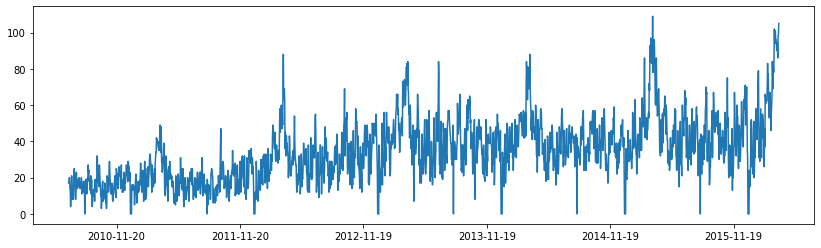

In [6]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_train['datetime'],df_train['y'])

ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=365, tz=None))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

Text(0.5, 1.0, 'client')

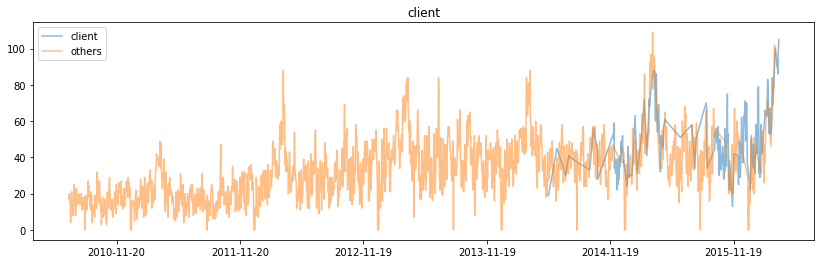

In [7]:
#変数clientごと
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_train[df_train['client']==1]['datetime'],df_train[df_train['client']==1]['y'],label='client',alpha=0.5)
ax.plot(df_train[df_train['client']==0]['datetime'],df_train[df_train['client']==0]['y'],label='others',alpha=0.5)
plt.legend()
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=365, tz=None))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.title('client')

Text(0.5, 1.0, 'close')

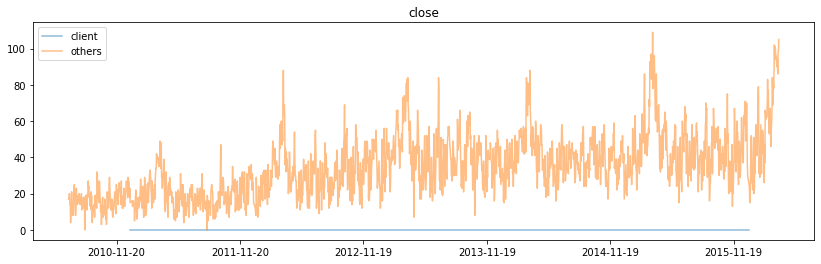

In [8]:
#変数closeごと
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_train[df_train['close']==1]['datetime'],df_train[df_train['close']==1]['y'],label='client',alpha=0.5)
ax.plot(df_train[df_train['close']==0]['datetime'],df_train[df_train['close']==0]['y'],label='others',alpha=0.5)
plt.legend()
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=365, tz=None))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.title('close')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Text(0.5, 1.0, 'pm_price')

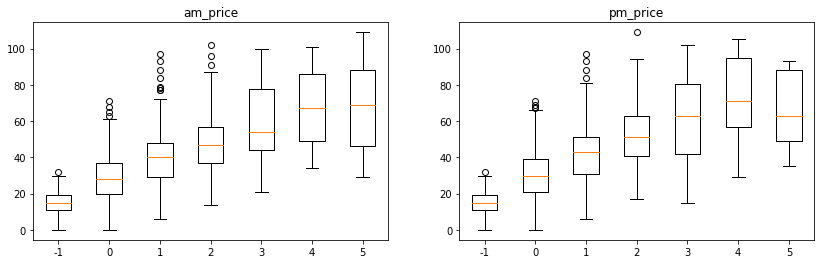

In [9]:
#am_price / pm_price
plt.figure(figsize=(14,4))
l1 = []
for i in sorted(df_train['price_am'].unique()):
  l1.append(df_train[df_train['price_am']==i]['y'])

l2 = []
for i in sorted(df_train['price_pm'].unique()):
  l2.append(df_train[df_train['price_pm']==i]['y'])

plt.subplot(1,2,1)
plt.boxplot(l1,labels=sorted(df_train['price_am'].unique()))
plt.title('am_price')
plt.subplot(1,2,2)
plt.boxplot(l2,labels=sorted(df_train['price_pm'].unique()))
plt.title('pm_price')

# 3.

In [10]:
#prophet用に変数名を変更し、一旦余計な変数を落とす
df_train_ = df_train.rename(columns={'datetime':'ds'})[['ds','y']]

display(df_train_)

,ds,y
0,2010-07-01,17
1,2010-07-02,18
2,2010-07-03,20
3,2010-07-04,20
4,2010-07-05,14
...,...,...
2096,2016-03-27,94
2097,2016-03-28,86
2098,2016-03-29,98
2099,2016-03-30,99


## 3.1 シンプルモデル

In [11]:
#モデルフィット
m = Prophet()
m.fit(df_train_)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


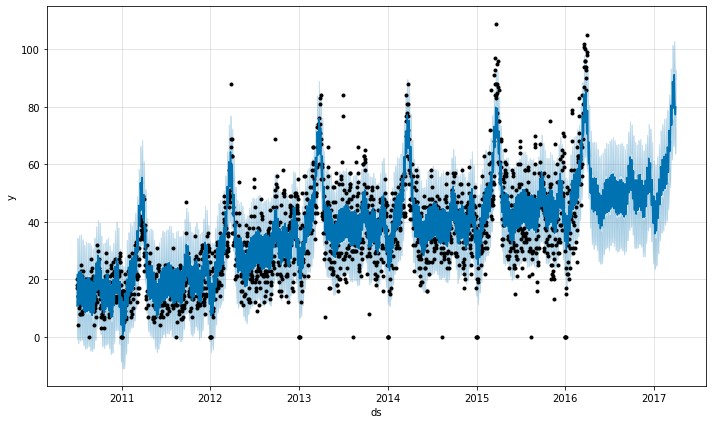

In [12]:
#モデル予測
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [13]:
#モデルをMAEで検証
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
np.abs(df_cv['y'] - df_cv['yhat']).groupby(df_cv['cutoff']).mean().sort_index()

INFO:prophet:Making 6 forecasts with cutoffs between 2012-10-13 00:00:00 and 2015-04-01 00:00:00


cutoff
2012-10-13     9.304026
2013-04-11    12.171601
2013-10-08    13.391403
2014-04-06     8.006557
2014-10-03     9.507728
2015-04-01     9.890168
dtype: float64

## 3.2

In [14]:
#日本の祝日
m = Prophet()
m.add_country_holidays(country_name='JP')
m.fit(df_train_)
m.train_holiday_names

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0         元日
1       成人の日
2     建国記念の日
3       春分の日
4       昭和の日
5      憲法記念日
6      みどりの日
7      こどもの日
8        海の日
9        山の日
10      敬老の日
11      秋分の日
12      体育の日
13      文化の日
14    勤労感謝の日
15     天皇誕生日
16      振替休日
17     国民の休日
dtype: object

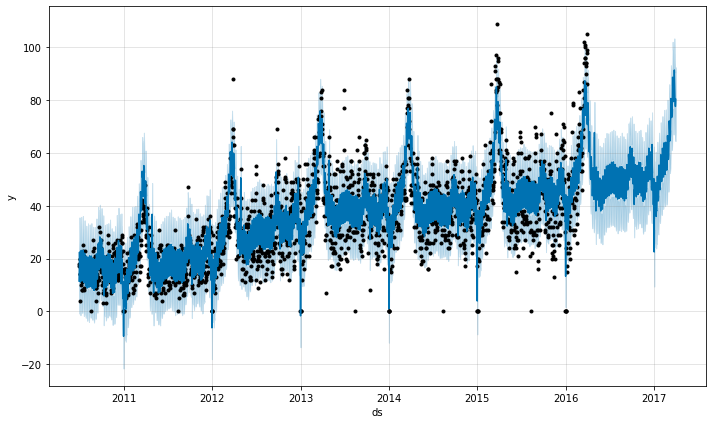

In [15]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [16]:
#モデルをMAEで検証
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
np.abs(df_cv['y'] - df_cv['yhat']).groupby(df_cv['cutoff']).mean().sort_index()

INFO:prophet:Making 6 forecasts with cutoffs between 2012-10-13 00:00:00 and 2015-04-01 00:00:00


cutoff
2012-10-13     9.199576
2013-04-11    12.129924
2013-10-08    13.302574
2014-04-06     7.852528
2014-10-03     9.401197
2015-04-01     9.808105
dtype: float64

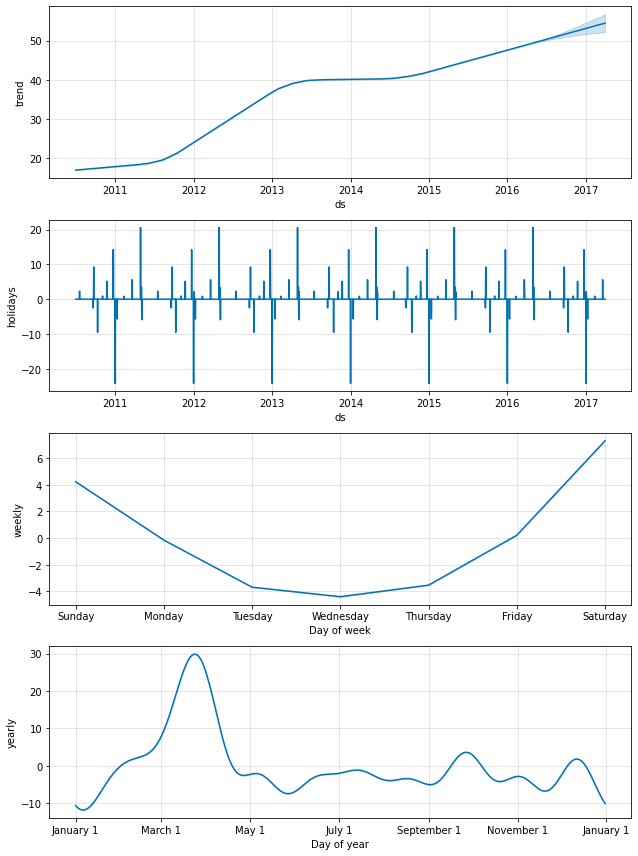

In [17]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot_components(forecast)

## 3.3

In [18]:
m = Prophet()
m.add_country_holidays(country_name='JP') #祝日追加
m.add_seasonality(name='monthly', period=30.5, fourier_order=5) #月次季節性(30.5日)追加 
m.add_regressor('client') #元データにあるclient追加
m.add_regressor('close') #元データにあるclose追加
m.add_regressor('price_am') #元データにあるprice_am追加
m.add_regressor('price_pm') #元データにあるprice_pm追加

#各種変数を学習データdf_train_に追加
df_train_['client'] = df_train['client'] 
df_train_['close'] = df_train['close'] 

df_train_['price_am'] = df_train['price_am'] 
df_train_['price_pm'] = df_train['price_pm'] 

m.fit(df_train_)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


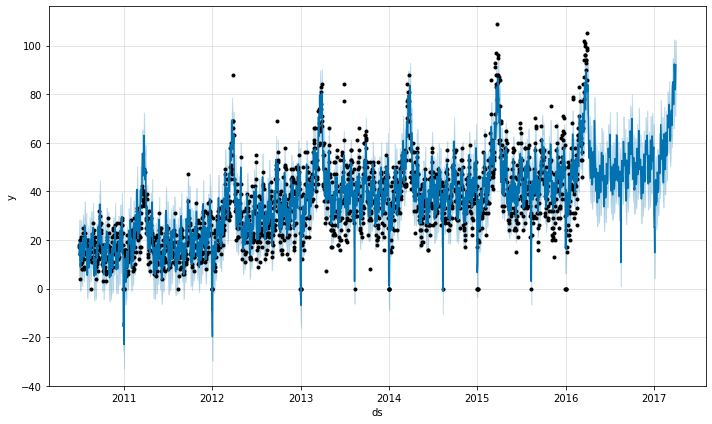

In [19]:
future = m.make_future_dataframe(periods=365)

#各種変数を予測データfutureに追加
future['client'] = pd.concat([df_train['client'],df_test['client']]).reset_index(drop=True)
future['close'] = pd.concat([df_train['close'],df_test['close']]).reset_index(drop=True)
future['price_am'] = pd.concat([df_train['price_am'],df_test['price_am']]).reset_index(drop=True)
future['price_pm'] = pd.concat([df_train['price_pm'],df_test['price_pm']]).reset_index(drop=True)

forecast = m.predict(future)
fig1 = m.plot(forecast)

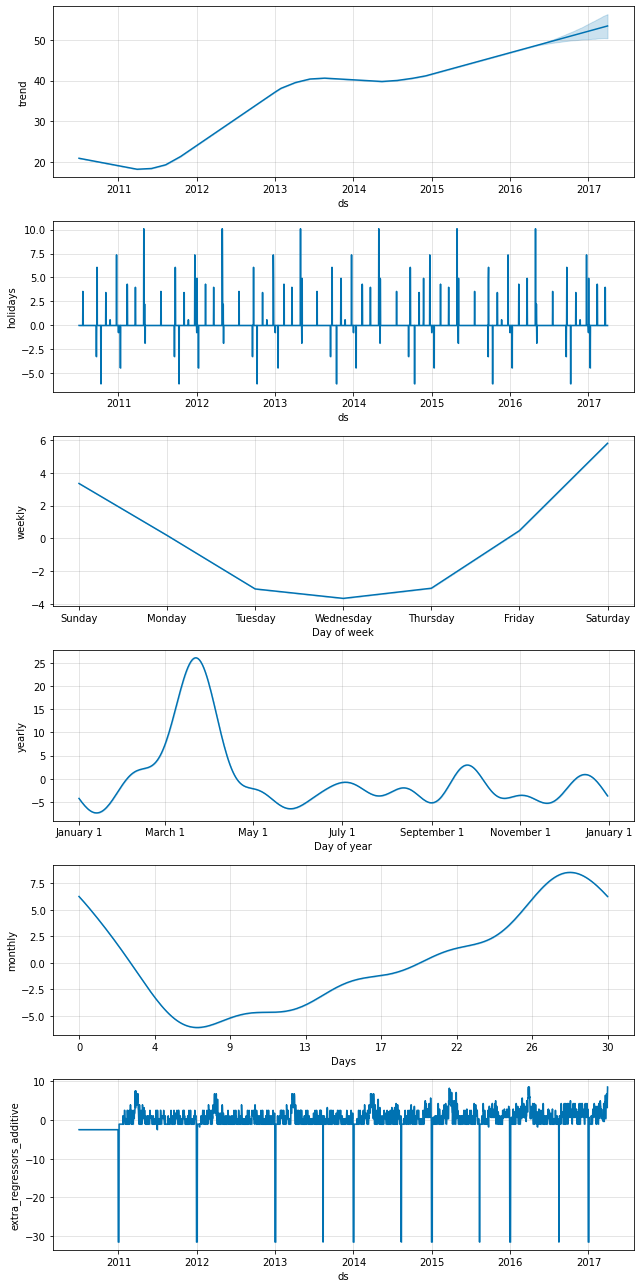

In [20]:
fig = m.plot_components(forecast)

In [21]:
#モデルをMAEで検証
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
np.abs(df_cv['y'] - df_cv['yhat']).groupby(df_cv['cutoff']).mean().sort_index()

INFO:prophet:Making 6 forecasts with cutoffs between 2012-10-13 00:00:00 and 2015-04-01 00:00:00


cutoff
2012-10-13     7.186252
2013-04-11    11.337781
2013-10-08    12.008329
2014-04-06     6.778707
2014-10-03     8.217344
2015-04-01     8.468081
dtype: float64

In [22]:
forecast[forecast['ds']>='2016-04-01'][['ds','yhat']].to_csv('submit.csv',index=False)

## 3.4 土用の日

In [23]:
import datetime
do = [pd.to_datetime(str(y)+'-01-17')+datetime.timedelta(days=i) for i in range(18) for y in range(2010,2018)] + [pd.to_datetime(str(y)+'-04-17')+datetime.timedelta(days=i) for i in range(18) for y in range(2010,2018)]\
+ [pd.to_datetime(str(y)+'-07-19')+datetime.timedelta(days=i) for i in range(18) for y in range(2010,2018)] + [pd.to_datetime(str(y)+'-10-20')+datetime.timedelta(days=i) for i in range(18) for y in range(2010,2018)]
doyou = pd.DataFrame({
  'holiday': 'doyou',
  'ds': do,
  'lower_window': 0,
  'upper_window': 1,
})
doyou.sort_values(by=['ds'],inplace=True)

In [24]:
m = Prophet(holidays=doyou)
m.add_country_holidays(country_name='JP') #祝日追加
m.add_seasonality(name='monthly', period=30.5, fourier_order=5) #月次季節性(30.5日)追加 
m.add_regressor('client') #元データにあるclient追加
m.add_regressor('close') #元データにあるclose追加
m.add_regressor('price_am') #元データにあるprice_am追加
m.add_regressor('price_pm') #元データにあるprice_pm追加

#各種変数を学習データdf_train_に追加
df_train_['client'] = df_train['client'] 
df_train_['close'] = df_train['close'] 

df_train_['price_am'] = df_train['price_am'] 
df_train_['price_pm'] = df_train['price_pm'] 

m.fit(df_train_)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


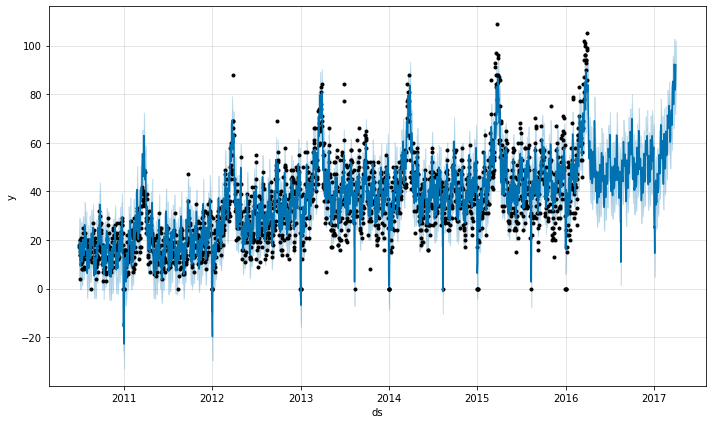

In [25]:
future = m.make_future_dataframe(periods=365)

#各種変数を予測データfutureに追加
future['client'] = pd.concat([df_train['client'],df_test['client']]).reset_index(drop=True)
future['close'] = pd.concat([df_train['close'],df_test['close']]).reset_index(drop=True)
future['price_am'] = pd.concat([df_train['price_am'],df_test['price_am']]).reset_index(drop=True)
future['price_pm'] = pd.concat([df_train['price_pm'],df_test['price_pm']]).reset_index(drop=True)

forecast = m.predict(future)
fig1 = m.plot(forecast)

In [26]:
#モデルをMAEで検証
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
np.abs(df_cv['y'] - df_cv['yhat']).groupby(df_cv['cutoff']).mean().sort_index()

INFO:prophet:Making 6 forecasts with cutoffs between 2012-10-13 00:00:00 and 2015-04-01 00:00:00


cutoff
2012-10-13     7.190485
2013-04-11    11.243173
2013-10-08    12.141659
2014-04-06     6.735326
2014-10-03     8.185130
2015-04-01     8.462683
dtype: float64

## 3.5 mulutiplicative seasnarity

In [27]:
m = Prophet(seasonality_mode='multiplicative')
m.add_country_holidays(country_name='JP') #祝日追加
m.add_seasonality(name='monthly', period=30.5, fourier_order=5) #月次季節性(30.5日)追加 
m.add_regressor('client') #元データにあるclient追加
m.add_regressor('close') #元データにあるclose追加
m.add_regressor('price_am') #元データにあるprice_am追加
m.add_regressor('price_pm') #元データにあるprice_pm追加

#各種変数を学習データdf_train_に追加
df_train_['client'] = df_train['client'] 
df_train_['close'] = df_train['close'] 

df_train_['price_am'] = df_train['price_am'] 
df_train_['price_pm'] = df_train['price_pm'] 

m.fit(df_train_)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


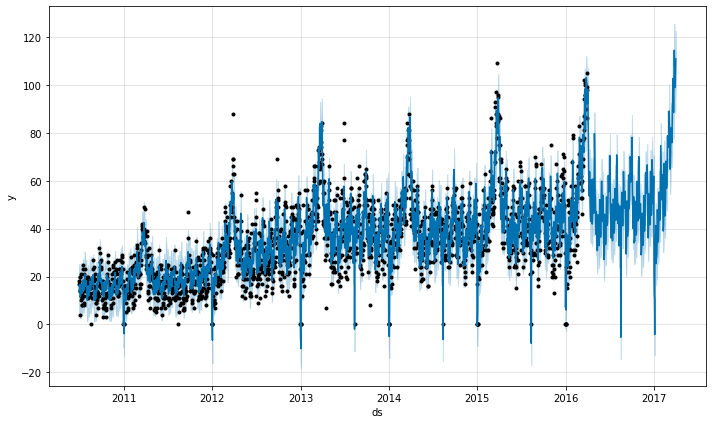

In [28]:
future = m.make_future_dataframe(periods=365)

#各種変数を予測データfutureに追加
future['client'] = pd.concat([df_train['client'],df_test['client']]).reset_index(drop=True)
future['close'] = pd.concat([df_train['close'],df_test['close']]).reset_index(drop=True)
future['price_am'] = pd.concat([df_train['price_am'],df_test['price_am']]).reset_index(drop=True)
future['price_pm'] = pd.concat([df_train['price_pm'],df_test['price_pm']]).reset_index(drop=True)

forecast = m.predict(future)
fig1 = m.plot(forecast)

In [29]:
#モデルをMAEで検証
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
np.abs(df_cv['y'] - df_cv['yhat']).groupby(df_cv['cutoff']).mean().sort_index()

INFO:prophet:Making 6 forecasts with cutoffs between 2012-10-13 00:00:00 and 2015-04-01 00:00:00


cutoff
2012-10-13     7.090912
2013-04-11     7.859049
2013-10-08    13.055979
2014-04-06    10.459048
2014-10-03     8.922574
2015-04-01     7.587385
dtype: float64

In [30]:
forecast[forecast['ds']>='2016-04-01'][['ds','yhat']].to_csv('submit.csv',index=False)

研修内容はここまで、これ以降は追加分析したものでpptないでは触れていない

## 3.6 3.5 + 2013以降のみのデータ

In [31]:
m = Prophet(seasonality_mode='multiplicative')
m.add_country_holidays(country_name='JP') #祝日追加
m.add_seasonality(name='monthly', period=30.5, fourier_order=5) #月次季節性(30.5日)追加 
m.add_regressor('client') #元データにあるclient追加
m.add_regressor('close') #元データにあるclose追加
m.add_regressor('price_am') #元データにあるprice_am追加
m.add_regressor('price_pm') #元データにあるprice_pm追加

#各種変数を学習データdf_train_に追加
df_train_['client'] = df_train['client'] 
df_train_['close'] = df_train['close'] 

df_train_['price_am'] = df_train['price_am'] 
df_train_['price_pm'] = df_train['price_pm'] 
df_train_1 = df_train_[df_train_['ds']>='2013-01-01']
m.fit(df_train_1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


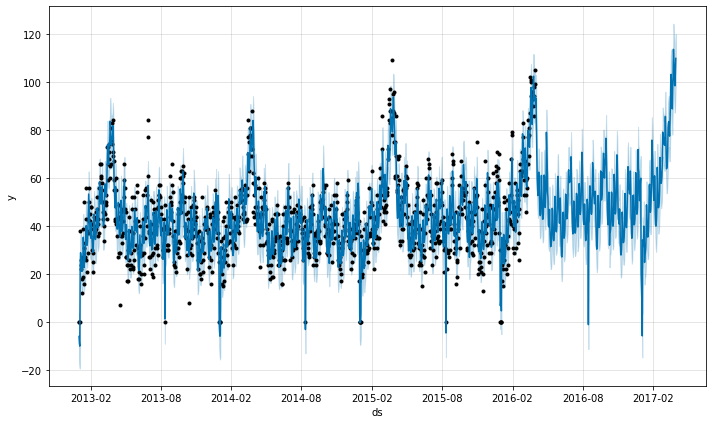

In [32]:
future = m.make_future_dataframe(periods=365)

#各種変数を予測データfutureに追加
future['client'] = pd.concat([df_train[df_train['datetime']>='2013-01-01']['client'],df_test['client']]).reset_index(drop=True)
future['close'] = pd.concat([df_train[df_train['datetime']>='2013-01-01']['close'],df_test['close']]).reset_index(drop=True)
future['price_am'] = pd.concat([df_train[df_train['datetime']>='2013-01-01']['price_am'],df_test['price_am']]).reset_index(drop=True)
future['price_pm'] = pd.concat([df_train[df_train['datetime']>='2013-01-01']['price_pm'],df_test['price_pm']]).reset_index(drop=True)

forecast = m.predict(future)
fig1 = m.plot(forecast)

In [33]:
#モデルをMAEで検証
df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '365 days')
np.abs(df_cv['y'] - df_cv['yhat']).groupby(df_cv['cutoff']).mean().sort_index()

INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


cutoff
2015-01-01    9.068517
2015-04-01    9.613762
dtype: float64

In [34]:
forecast[forecast['ds']>='2016-04-01'][['ds','yhat']].to_csv('submit.csv',index=False)

## 3.7 3.6 + 土用

In [35]:
import datetime
do = [pd.to_datetime(str(y)+'-01-17')+datetime.timedelta(days=i) for i in range(18) for y in range(2010,2018)] + [pd.to_datetime(str(y)+'-04-17')+datetime.timedelta(days=i) for i in range(18) for y in range(2010,2018)]\
+ [pd.to_datetime(str(y)+'-07-19')+datetime.timedelta(days=i) for i in range(18) for y in range(2010,2018)] + [pd.to_datetime(str(y)+'-10-20')+datetime.timedelta(days=i) for i in range(18) for y in range(2010,2018)]
doyou = pd.DataFrame({
  'holiday': 'doyou',
  'ds': do,
  'lower_window': 0,
  'upper_window': 1,
})
doyou.sort_values(by=['ds'],inplace=True)

In [36]:
m = Prophet(holidays=doyou,seasonality_mode='multiplicative')
m.add_country_holidays(country_name='JP') #祝日追加
m.add_seasonality(name='monthly', period=30.5, fourier_order=5) #月次季節性(30.5日)追加 
m.add_regressor('client') #元データにあるclient追加
m.add_regressor('close') #元データにあるclose追加
m.add_regressor('price_am') #元データにあるprice_am追加
m.add_regressor('price_pm') #元データにあるprice_pm追加

#各種変数を学習データdf_train_に追加
df_train_['client'] = df_train['client'] 
df_train_['close'] = df_train['close'] 

df_train_['price_am'] = df_train['price_am'] 
df_train_['price_pm'] = df_train['price_pm'] 
df_train_1 = df_train_[df_train_['ds']>='2013-01-01']
m.fit(df_train_1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


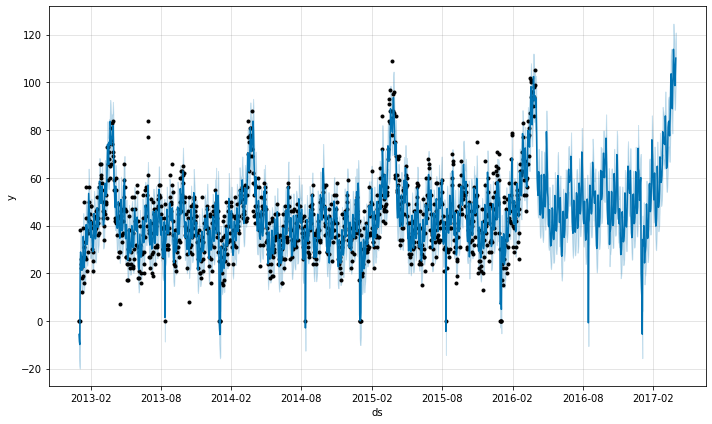

In [37]:
future = m.make_future_dataframe(periods=365)

#各種変数を予測データfutureに追加
future['client'] = pd.concat([df_train[df_train['datetime']>='2013-01-01']['client'],df_test['client']]).reset_index(drop=True)
future['close'] = pd.concat([df_train[df_train['datetime']>='2013-01-01']['close'],df_test['close']]).reset_index(drop=True)
future['price_am'] = pd.concat([df_train[df_train['datetime']>='2013-01-01']['price_am'],df_test['price_am']]).reset_index(drop=True)
future['price_pm'] = pd.concat([df_train[df_train['datetime']>='2013-01-01']['price_pm'],df_test['price_pm']]).reset_index(drop=True)

forecast = m.predict(future)
fig1 = m.plot(forecast)

In [38]:
#モデルをMAEで検証
df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '365 days')
np.abs(df_cv['y'] - df_cv['yhat']).groupby(df_cv['cutoff']).mean().sort_index()

INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


cutoff
2015-01-01    9.074259
2015-04-01    9.690686
dtype: float64

## 3.8 3.6 + yhat の加工

In [73]:
m = Prophet(seasonality_mode='multiplicative')
m.add_country_holidays(country_name='JP') #祝日追加
m.add_seasonality(name='monthly', period=30.5, fourier_order=5) #月次季節性(30.5日)追加 
#m.add_seasonality('quarterly', period=91.25, fourier_order=8)
m.add_regressor('client') #元データにあるclient追加
m.add_regressor('close') #元データにあるclose追加
m.add_regressor('price_am') #元データにあるprice_am追加
m.add_regressor('price_pm') #元データにあるprice_pm追加

#各種変数を学習データdf_train_に追加
df_train_['client'] = df_train['client'] 
df_train_['close'] = df_train['close'] 

df_train_['price_am'] = df_train['price_am'] 
df_train_['price_pm'] = df_train['price_pm'] 
df_train_1 = df_train_[df_train_['ds']>='2013-01-01']
m.fit(df_train_1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


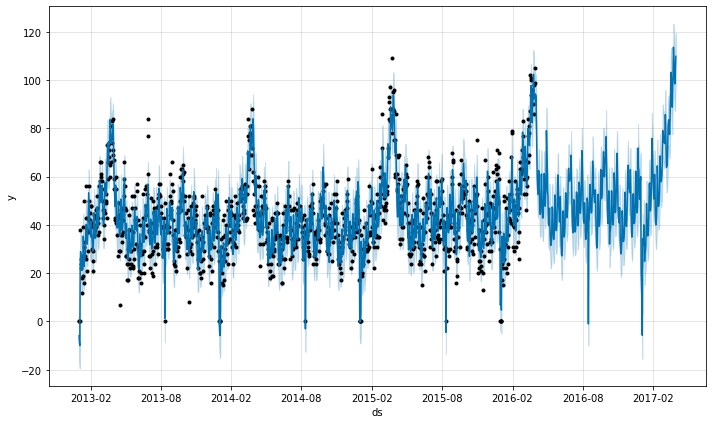

In [74]:
future = m.make_future_dataframe(periods=365)

#各種変数を予測データfutureに追加
future['client'] = pd.concat([df_train[df_train['datetime']>='2013-01-01']['client'],df_test['client']]).reset_index(drop=True)
future['close'] = pd.concat([df_train[df_train['datetime']>='2013-01-01']['close'],df_test['close']]).reset_index(drop=True)
future['price_am'] = pd.concat([df_train[df_train['datetime']>='2013-01-01']['price_am'],df_test['price_am']]).reset_index(drop=True)
future['price_pm'] = pd.concat([df_train[df_train['datetime']>='2013-01-01']['price_pm'],df_test['price_pm']]).reset_index(drop=True)

forecast = m.predict(future)
fig1 = m.plot(forecast)

In [75]:
forecast.loc[future['close']==1,'yhat'] = 0
forecast.loc[forecast['yhat']<0,'yhat'] = 0

In [78]:
#モデルをMAEで検証
df_cv = cross_validation(m, initial='730 days', period='30 days', horizon = '365 days')
df_cv.loc[df_cv['yhat']<0,'yhat'] = 0 
cv = np.abs(df_cv['y'] - df_cv['yhat']).groupby(df_cv['cutoff']).mean().sort_index()
display(cv)
cv.mean()

INFO:prophet:Making 4 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


cutoff
2015-01-01    9.063110
2015-01-31    9.270922
2015-03-02    8.330043
2015-04-01    9.606845
dtype: float64

9.06773008174504

In [44]:
forecast[forecast['ds']>='2016-04-01'][['ds','yhat']].to_csv('submit.csv',index=False)

In [45]:
forecast[forecast['ds']>='2016-04-01'][['ds','yhat']]

,ds,yhat
1186,2016-04-01,89.622275
1187,2016-04-02,93.135894
1188,2016-04-03,81.371413
1189,2016-04-04,69.543663
1190,2016-04-05,59.784222
...,...,...
1546,2017-03-27,106.052139
1547,2017-03-28,98.862629
1548,2017-03-29,98.423798
1549,2017-03-30,103.971799


## 3.9 3.8に変数追加

https://qiita.com/bo-no/items/2a9cacd9d5a371a23df1

In [81]:
# import datetime
# do = [pd.to_datetime(str(y)+'-12-24')+datetime.timedelta(days=i) for i in range(2) for y in range(2010,2018)] + [pd.to_datetime(str(y)+'-12-31')+datetime.timedelta(days=i) for i in range(4) for y in range(2010,2018)]
# doyou = pd.DataFrame({
#   'holiday': 'doyou',
#   'ds': do,
#   'lower_window': 0,
#   'upper_window': 1,
# })
# doyou.sort_values(by=['ds'],inplace=True)

In [82]:
#read table
df_train = pd.read_csv('train.csv',parse_dates=[0])
df_test = pd.read_csv('test.csv',parse_dates=[0])

# df=pd.concat([df_train,df_test])

# print (df_train.shape,df_test.shape)

In [83]:
# df['oneday_before_am'] = df['price_am'].shift(1)
# df['oneday_before_pm'] = df['price_pm'].shift(1)
# df['rel_3am'] = df['price_am'].rolling(7).sum()
# df['rel_3pm'] = df['price_pm'].rolling(7).sum()
# df['rel_3cli'] = df['client'].rolling(7).sum()
# df['rel_3clo'] = df['close'].rolling(7).sum()

# df_train = pd.merge(df_train,df[['datetime','oneday_before_am','oneday_before_pm','rel_3am','rel_3pm','rel_3cli','rel_3clo']],on='datetime',how='inner')
# df_test = pd.merge(df_test,df[['datetime','oneday_before_am','oneday_before_pm','rel_3am','rel_3pm','rel_3cli','rel_3clo']],on='datetime',how='inner')

# print (df_train.shape,df_test.shape)

In [84]:
#追加変数

df_train['am_pm'] = df_train['price_am']-df_train['price_pm']
#ラグ特徴量、移動平均、日付
# df_train['oneday_before_am'] = df_train['price_am'].shift(1)
# df_train['oneday_before_pm'] = df_train['price_pm'].shift(1)
# df_train['rel_3am'] = df_train['price_am'].rolling(7).sum()
# df_train['rel_3pm'] = df_train['price_pm'].rolling(7).sum()
# df_train['rel_3cli'] = df_train['client'].rolling(7).sum()
# df_train['rel_3clo'] = df_train['close'].rolling(7).sum()

df_test['am_pm'] = df_test['price_am']-df_test['price_pm']
#ラグ特徴量、移動平均、日付
# df_test['oneday_before_am'] = df_test['price_am'].shift(1)
# df_test['oneday_before_pm'] = df_test['price_pm'].shift(1)
# df_test['rel_3am'] = df_test['price_am'].rolling(7).sum()
# df_test['rel_3pm'] = df_test['price_pm'].rolling(7).sum()
# df_test['rel_3cli'] = df_test['client'].rolling(7).sum()
# df_test['rel_3clo'] = df_test['close'].rolling(7).sum()		


In [85]:
m = Prophet(seasonality_mode='multiplicative')
m.add_country_holidays(country_name='JP') #祝日追加
m.add_seasonality(name='monthly', period=30.5, fourier_order=5) #月次季節性(30.5日)追加 
#m.add_seasonality('quarterly', period=91.25, fourier_order=8)
m.add_regressor('client') #元データにあるclient追加
m.add_regressor('close') #元データにあるclose追加
m.add_regressor('price_am') #元データにあるprice_am追加
m.add_regressor('price_pm') #元データにあるprice_pm追加

m.add_regressor('am_pm') #新規作成した変数

# m.add_regressor('oneday_before_am') #新規作成した変数
# m.add_regressor('oneday_before_pm') #新規作成した変数
# m.add_regressor('rel_3am') #新規作成した変数
# m.add_regressor('rel_3pm') #新規作成した変数
# m.add_regressor('rel_3cli') #新規作成した変数
# m.add_regressor('rel_3clo') #新規作成した変数

#各種変数を学習データdf_train_に追加
df_train_['client'] = df_train['client'] 
df_train_['close'] = df_train['close'] 
df_train_['price_am'] = df_train['price_am'] 
df_train_['price_pm'] = df_train['price_pm'] 

df_train_['am_pm'] = df_train['am_pm']
# df_train_['oneday_before_am'] = df_train['oneday_before_am']
# df_train_['oneday_before_pm'] = df_train['oneday_before_pm']
# df_train_['rel_3am'] = df_train['rel_3am']
# df_train_['rel_3pm'] = df_train['rel_3pm']
# df_train_['rel_3cli'] = df_train['rel_3cli']
# df_train_['rel_3clo'] = df_train['rel_3clo']


df_train_1 = df_train_[df_train_['ds']>='2013-01-01']
m.fit(df_train_1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


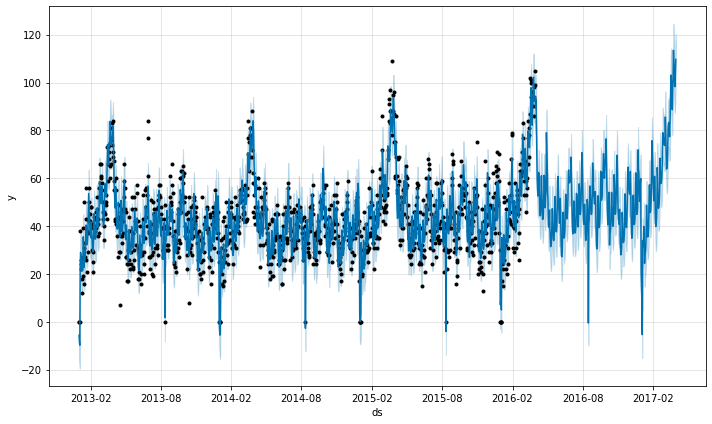

In [86]:
vars = ['client','close','price_am','price_pm','am_pm']
future = m.make_future_dataframe(periods=365)

for var in vars:
  #各種変数を予測データfutureに追加
  future[var] = pd.concat([df_train[df_train['datetime']>='2013-01-01'][var],df_test[var]]).reset_index(drop=True)
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [87]:
forecast.loc[future['close']==1,'yhat'] = 0
forecast.loc[forecast['yhat']<0,'yhat'] = 0

In [88]:
#モデルをMAEで検証
df_cv = cross_validation(m, initial='730 days', period='30 days', horizon = '365 days')
df_cv.loc[df_cv['yhat']<0,'yhat'] = 0 
cv = np.abs(df_cv['y'] - df_cv['yhat']).groupby(df_cv['cutoff']).mean().sort_index()
display(cv)
cv.mean()

INFO:prophet:Making 4 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


cutoff
2015-01-01    9.019918
2015-01-31    9.262972
2015-03-02    8.361444
2015-04-01    9.565021
dtype: float64

9.052338503151383

In [72]:
forecast[forecast['ds']>='2016-04-01'][['ds','yhat']].to_csv('submit.csv',index=False)

## 3.10 Hyper Tuning using CV 

In [55]:
df_train = pd.read_csv('train.csv',parse_dates=[0])
df_test = pd.read_csv('test.csv',parse_dates=[0])

In [56]:
#追加変数
df_train['am_pm'] = df_train['price_am']-df_train['price_pm']

df_test['am_pm'] = df_test['price_am']-df_test['price_pm']

In [57]:
import itertools
param_grid = {  
    #'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'holidays_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
MAE = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
  m = Prophet(seasonality_mode='multiplicative',**params)
  m.add_country_holidays(country_name='JP') #祝日追加
  m.add_seasonality(name='monthly', period=30.5, fourier_order=5) #月次季節性(30.5日)追加 
  #m.add_seasonality('quarterly', period=91.25, fourier_order=8)
  m.add_regressor('client') #元データにあるclient追加
  m.add_regressor('close') #元データにあるclose追加
  m.add_regressor('price_am') #元データにあるprice_am追加
  m.add_regressor('price_pm') #元データにあるprice_pm追加

  m.add_regressor('am_pm') #新規作成した変数


  #各種変数を学習データdf_train_に追加
  df_train_['client'] = df_train['client'] 
  df_train_['close'] = df_train['close'] 
  df_train_['price_am'] = df_train['price_am'] 
  df_train_['price_pm'] = df_train['price_pm'] 

  df_train_['am_pm'] = df_train['am_pm']

  df_train_1 = df_train_[df_train_['ds']>='2013-01-01']
  m.fit(df_train_1)
  #m = Prophet(**params).fit(df)  # Fit model with given params
  df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '365 days')
  df_cv.loc[df_cv['yhat']<0,'yhat'] = 0 
  x = np.abs(df_cv['y'] - df_cv['yhat']).groupby(df_cv['cutoff']).mean().sort_index()
  MAE.append([x[0],x[1]])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 2 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


In [58]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['MAE'] = np.array(MAE).mean(axis=1)
print(tuning_results)

# Python
best_params = all_params[np.argmin(np.array(MAE).mean(axis=1))]
print(best_params)

    holidays_prior_scale  seasonality_prior_scale        MAE
0                  0.001                     0.01  16.698363
1                  0.001                     0.10   9.499091
2                  0.001                     1.00   9.341382
3                  0.001                    10.00   9.375275
4                  0.010                     0.01  13.260378
5                  0.010                     0.10   9.486338
6                  0.010                     1.00   9.395643
7                  0.010                    10.00   9.426341
8                  0.100                     0.01  12.004374
9                  0.100                     0.10   9.328381
10                 0.100                     1.00   9.264754
11                 0.100                    10.00   9.269791
12                 0.500                     0.01  12.053898
13                 0.500                     0.10   9.383810
14                 0.500                     1.00   9.204392
15                 0.500

In [89]:
m = Prophet(seasonality_mode='multiplicative',seasonality_prior_scale=1.0,holidays_prior_scale=0.5)
m.add_country_holidays(country_name='JP') #祝日追加
m.add_seasonality(name='monthly', period=30.5, fourier_order=5) #月次季節性(30.5日)追加 
#m.add_seasonality('quarterly', period=91.25, fourier_order=8)
m.add_regressor('client') #元データにあるclient追加
m.add_regressor('close') #元データにあるclose追加
m.add_regressor('price_am') #元データにあるprice_am追加
m.add_regressor('price_pm') #元データにあるprice_pm追加

m.add_regressor('am_pm') #新規作成した変数


#各種変数を学習データdf_train_に追加
df_train_['client'] = df_train['client'] 
df_train_['close'] = df_train['close'] 
df_train_['price_am'] = df_train['price_am'] 
df_train_['price_pm'] = df_train['price_pm'] 

df_train_['am_pm'] = df_train['am_pm']

df_train_1 = df_train_[df_train_['ds']>='2013-01-01']
m.fit(df_train_1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


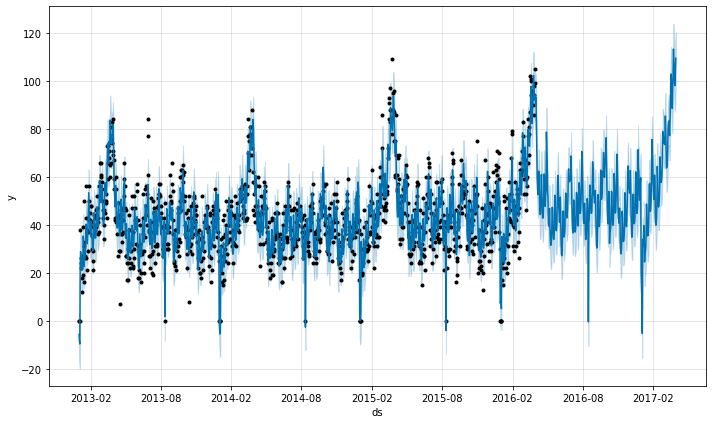

In [90]:
vars = ['client','close','price_am','price_pm','am_pm']
future = m.make_future_dataframe(periods=365)

for var in vars:
  #各種変数を予測データfutureに追加
  future[var] = pd.concat([df_train[df_train['datetime']>='2013-01-01'][var],df_test[var]]).reset_index(drop=True)
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [91]:
forecast.loc[future['close']==1,'yhat'] = 0
forecast.loc[forecast['yhat']<0,'yhat'] = 0

In [92]:
#モデルをMAEで検証
df_cv = cross_validation(m, initial='730 days', period='30 days', horizon = '365 days')
df_cv.loc[df_cv['yhat']<0,'yhat'] = 0 
cv = np.abs(df_cv['y'] - df_cv['yhat']).groupby(df_cv['cutoff']).mean().sort_index()
display(cv)
cv.mean()

INFO:prophet:Making 4 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-04-01 00:00:00


cutoff
2015-01-01    9.025475
2015-01-31    9.159293
2015-03-02    8.321595
2015-04-01    9.383309
dtype: float64

8.972417983686292

In [63]:
 forecast[forecast['ds']>='2016-04-01'][['ds','yhat']].to_csv('submit.csv',index=False)